In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm

import tensorflow as tf

import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics
from keras.models import load_model

from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/utk-face-extracted-info/extracted_info.csv')
df.dropna(inplace=True)
df = df[df['Age'] <= 90]
# df = df[df['Age'] > 16]
df = df[df['Age'] >= 0]
df = df.reset_index()
df = df.drop(columns = {'DateTime', 'Unnamed: 0', 'index'})

'''
'''
# df['Name'] = df['Name'].apply(lambda x: '../input/utkface-new/UTKFace/' + str(x))
'''
'''
num_classes = len(df['Age'].unique())
df.head()

,Age,Gender,Race,Name
0,42,0.0,0,../input/utkface-uncropped-dataset/Images/42_0...
1,88,0.0,2,../input/utkface-uncropped-dataset/Images/88_0...
2,35,1.0,0,../input/utkface-uncropped-dataset/Images/35_1...
3,26,0.0,3,../input/utkface-uncropped-dataset/Images/26_0...
4,42,1.0,1,../input/utkface-uncropped-dataset/Images/42_1...


## Visualising Some Images in the Dataset

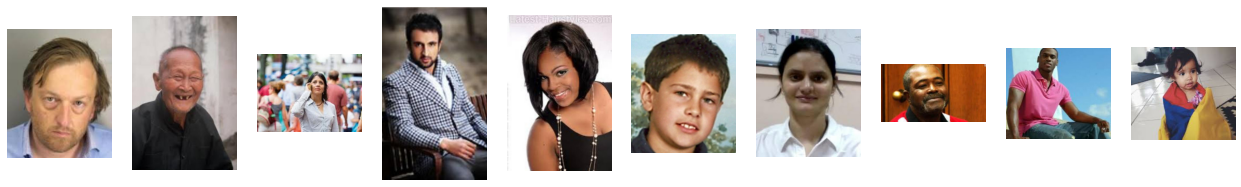

In [3]:
fig = plt.figure(figsize=(22, 5))
for i in range(10):  
    fig.add_subplot(1, 10, i+1)
    img = mpimg.imread(df.iloc[i]['Name'])
#     img = np.random.randint(10, size=(h,w))
    plt.imshow(img)
    plt.axis('off')
#     plt.title("Figure" + str(i))
plt.show()

## Age, Gender and Race Distribution in the original Dataset

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>],
       [<AxesSubplot:title={'center':'Race'}>, <AxesSubplot:>]],
      dtype=object)

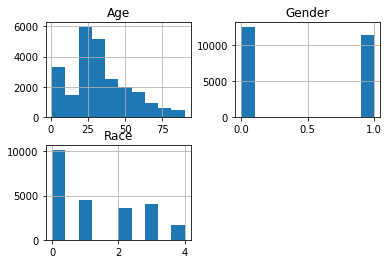

In [4]:
df.hist()
# df[df['Age'] < 16]

In [5]:
'''
len(df[df['Age']>93]['Age']) ------- just 46 people
classes = 101 #(0, 100])
print("number of output classes: ",classes)
'''

df['Age'] = df['Age'] - 1
# df['Age'] = df['Age'] - 16

In [6]:
# dff = df[df['Race'] == 3]
# dff['Age'].hist()

In [7]:
df_data = df.Name
y_data = df.Age
# y2_data = df.Gender
X_train, X_test, y_train, y_test = train_test_split(df_data, y_data, test_size=0.20, random_state=45)
d = {'Name':X_train,'Age':y_train}
df_train = pd.concat(d,axis=1)
df_train.head(3)

,Name,Age
17025,../input/utkface-uncropped-dataset/Images/68_1...,67
10905,../input/utkface-uncropped-dataset/Images/4_1_...,3
23908,../input/utkface-uncropped-dataset/Images/4_1_...,3


In [8]:
df_data = df_train.Name
y_data = df_train.Age
# y2_data = df.Gender
X_train, X_val, y_train, y_val = train_test_split(df_data, y_data, test_size=0.1, random_state=20)
d = {'Name':X_train,'Age':y_train}
train = pd.concat(d,axis=1)
train.head(3)

,Name,Age
7677,../input/utkface-uncropped-dataset/Images/35_0...,34
23426,../input/utkface-uncropped-dataset/Images/53_0...,52
4439,../input/utkface-uncropped-dataset/Images/35_0...,34


In [9]:
d = {'Name':X_val,'Age':y_val}
val = pd.concat(d,axis=1)
print(val.head(3))
###################
d = {'Name':X_test,'Age':y_test}
df_test = pd.concat(d,axis=1)
print(df_test.head(3))

                                                    Name  Age
17851  ../input/utkface-uncropped-dataset/Images/30_0...   29
20599  ../input/utkface-uncropped-dataset/Images/1_1_...    0
13450  ../input/utkface-uncropped-dataset/Images/60_1...   59
                                                   Name  Age
6109  ../input/utkface-uncropped-dataset/Images/26_0...   25
4463  ../input/utkface-uncropped-dataset/Images/29_0...   28
1553  ../input/utkface-uncropped-dataset/Images/26_1...   25


In [10]:
train['Age'] = train['Age'].astype('str')
df_test['Age'] = df_test['Age'].astype('str')
val['Age'] = val['Age'].astype('str')

## Visualising Race Distribution In the train dataset.

<AxesSubplot:>

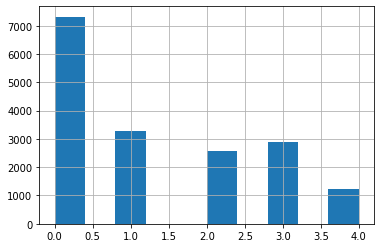

In [11]:
len(df[df['Age']>=80])
pd.merge(df, train, on='Name')['Race'].hist()

## Generating the Test, Train and Validation Datasets

In [12]:
batch = 512
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
train_data = train_gen.flow_from_dataframe(dataframe = train, 
                                           #directory = train_folder, 
                                           x_col = 'Name',
                                           y_col = 'Age', seed = 42,
                                           batch_size = batch,
                                           shuffle = True, 
                                           class_mode="sparse",
                                           target_size = (224, 224))

test_data = test_gen.flow_from_dataframe(dataframe = df_test,
                                         #directory = test_folder,
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))

val_data = train_gen.flow_from_dataframe(dataframe = val, 
                                           #directory = train_folder, 
                                           x_col = 'Name',
                                           y_col = 'Age', seed = 42,
                                           batch_size = batch,
                                           shuffle = True, 
                                           class_mode="sparse",
                                           target_size = (224, 224))

Found 17288 validated image filenames belonging to 90 classes.
Found 4803 validated image filenames belonging to 90 classes.
Found 1922 validated image filenames belonging to 86 classes.


In [13]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
# model.add(Activation('softmax'))

# model.load_weights('../input/vggfaceweights/vgg_face_weights.h5')

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

model.add(Activation('softmax'))

In [14]:
model.output_shape

(None, 90)

## Loading Previously Trained Model

In [15]:
model.load_weights('../input/model-weights-for-utkface-dataset/age_model_weights_utk_1.h5')

In [16]:
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
  optimizer='adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='classification_age_model_utk.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

## Training

In [17]:
__train = False
if __train:
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs= 4,
        callbacks = [checkpointer, callback],
        shuffle=True
    )
    model.load_weights("./classification_age_model_utk.hdf5")
    model.save_weights('age_model_weights_utk.h5')

In [18]:
__train = False
if __train:
    for layer in model.layers[:-2]:
        layer.trainable = False

In [19]:
if __train:
    history = model.fit(
            train_data
            , epochs=2
            , validation_data=val_data
            , callbacks=[checkpointer]
            , shuffle=True
    )
    model = load_model("./classification_age_model_utk.hdf5")
    model.save_weights('age_model_weights_utk.h5')

# #     scores.append(score)

# # #restore the best weights

In [20]:
# A = model.predict_classes(test_data)
B = model.predict(test_data)
output_indexes = np.array([i for i in range(0, num_classes)])
apparent_predictions = np.sum(B * output_indexes, axis = 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [21]:
# df_test['Predictions'] = A
df_test['Predictions'] = apparent_predictions
df_test.to_csv('Final.csv')

In [22]:
MAE = 0
count = 0
for i in range(len(df_test)):
    if int(df_test.iloc[i]['Age']) < 16 or int(df_test.iloc[i]['Age']) > 80:
        continue
    count = count + 1
    MAE = MAE + abs(int(df_test.iloc[i]['Age']) - int(df_test.iloc[i]['Predictions']))
print("MAE is ", MAE/count)

MAE is  16.66117216117216


In [23]:
df_test

,Name,Age,Predictions
6109,../input/utkface-uncropped-dataset/Images/26_0...,25,20.670137
4463,../input/utkface-uncropped-dataset/Images/29_0...,28,80.494545
1553,../input/utkface-uncropped-dataset/Images/26_1...,25,42.662030
1818,../input/utkface-uncropped-dataset/Images/76_0...,75,22.410617
8819,../input/utkface-uncropped-dataset/Images/21_0...,20,57.510871
...,...,...,...
21672,../input/utkface-uncropped-dataset/Images/1_0_...,0,36.967721
15940,../input/utkface-uncropped-dataset/Images/21_1...,20,26.575310
22872,../input/utkface-uncropped-dataset/Images/88_1...,87,45.857718
12195,../input/utkface-uncropped-dataset/Images/4_0_...,3,19.761070


## Testing MAE For Separate Races

In [24]:
df_test_race = pd.merge(df, df_test, on="Name")

dff = [1, 2, 3, 4, 5]

dff[0] = df_test_race[df_test_race['Race'] == 0]
dff[1] = df_test_race[df_test_race['Race'] == 1]
dff[2] = df_test_race[df_test_race['Race'] == 2]
dff[3] = df_test_race[df_test_race['Race'] == 3]
dff[4] = df_test_race[df_test_race['Race'] == 4]

dff[0]['Age_x'] = dff[0]['Age_x'].astype('str')
dff[1]['Age_x'] = dff[1]['Age_x'].astype('str')
dff[2]['Age_x'] = dff[2]['Age_x'].astype('str')
dff[3]['Age_x'] = dff[3]['Age_x'].astype('str')
dff[4]['Age_x'] = dff[4]['Age_x'].astype('str')

In [25]:
batch = 512
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

test_data_race = [1, 2, 3 ,4 ,5]
test_data_race[0] = test_gen.flow_from_dataframe(dataframe = dff[0],
                                         x_col = 'Name',
                                         y_col = 'Age_x',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[1] = test_gen.flow_from_dataframe(dataframe = dff[1],
                                         x_col = 'Name',
                                         y_col = 'Age_x',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[2] = test_gen.flow_from_dataframe(dataframe = dff[2],
                                         x_col = 'Name',
                                         y_col = 'Age_x',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[3] = test_gen.flow_from_dataframe(dataframe = dff[3],
                                         x_col = 'Name',
                                         y_col = 'Age_x',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[4] = test_gen.flow_from_dataframe(dataframe = dff[4],
                                         x_col = 'Name',
                                         y_col = 'Age_x',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))

Found 2052 validated image filenames belonging to 90 classes.
Found 897 validated image filenames belonging to 79 classes.
Found 708 validated image filenames belonging to 75 classes.
Found 816 validated image filenames belonging to 73 classes.
Found 330 validated image filenames belonging to 54 classes.


In [26]:
for iii in range(len(df['Race'].unique())):
    mae = 0
    B = model.predict(test_data_race[iii])
    output_indexes = np.array([i for i in range(0, num_classes)])
    apparent_predictions = np.sum(B * output_indexes, axis = 1)
    dff[iii]['Predictions'] = apparent_predictions
    count = 0
    for i in range(len(dff[iii])):
        if int(dff[iii].iloc[i]['Age_x']) < 16 or int(df_test.iloc[i]['Age']) > 80:
            continue
        count = count +  1
        mae = mae + abs(int(dff[iii].iloc[i]['Age_x']) - int(dff[iii].iloc[i]['Predictions']))
    print("MAE is ", mae/count, "for race", iii)

MAE is  20.20725075528701 for race 0
MAE is  13.078979343863912 for race 1
MAE is  16.290870488322717 for race 2
MAE is  14.921686746987952 for race 3
MAE is  10.304932735426009 for race 4


In [27]:
model

<a href="./classification_age_model_utk.hdf5"> Download Model Weights </a>